In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import geopandas 
!pip install plotly
import plotly 
#plotly.tools.set_credentials_file(username='koshh', api_key='••••••••••')

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
plotly.offline.init_notebook_mode()
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
retaildf = pd.read_excel('Online Retail.xlsx')

In [3]:
retaildf.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
retaildf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Observations
'Description' and 'CustomerID' columns have null values.

Lets check if we can fill CustomerID from InvoiceNo.


In [5]:

# Check one-to-many mapping of some columns to check for data correctness

def isOneToMany(retaildf, col1, col2):
    first = retaildf.drop_duplicates([col1, col2]).groupby(col1)[col2].count().max()
    print(first == 1)

In [6]:
# Check if each InvoiceNo is unique to a CustomerID
isOneToMany(retaildf, 'InvoiceNo', 'CustomerID')

True


Considering we are not able to fill up CustomerID, and we have enough data, we will drop observations with NaN CustomerID


In [7]:

# Delete rows with missing CustomerID
retaildf = retaildf.drop(retaildf[retaildf.CustomerID.isnull()].index).reset_index(drop=True)
retaildf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [8]:
# Convert "InvoiceNo" to a string type series
retaildf['InvoiceNo'] = retaildf.InvoiceNo.astype('str')


In [9]:
# Convert "Description" to a string type series and remove extra whitespaces
retaildf['Description'] = retaildf.Description.astype('str')
retaildf['Description'] = retaildf.Description.str.strip()


In [10]:
# Check for data correctness based on one to many relationship between some columns

isOneToMany(retaildf,'InvoiceNo','Country')
isOneToMany(retaildf,'StockCode','Description')

True
False


StockCode and Description should have one-to-many relationship. Which means each StockCode needs to uniquely represent an item Description, but each Description may not have just one StockCode. But our dataset has multiple Description for same StockCode.

 analyzing ....


In [11]:

# Check duplicacy of description in StockCode

products = retaildf.groupby(['StockCode','Description'],as_index=False).count()
products = products.loc[:,['StockCode','Description']]
stockCount = products.StockCode.value_counts().to_frame()
stockList = list(stockCount[stockCount.StockCode>1].index) #List of stockCode with more than 1 Description
products[products.StockCode.isin(stockList)].head(10)

StockCode                          Description
48      20622                   VIP PASSPORT COVER
49      20622                    VIPPASSPORT COVER
101     20725              LUNCH BAG RED RETROSPOT
102     20725                 LUNCH BAG RED SPOTTY
194     20914  SET/5 RED RETROSPOT LID GLASS BOWLS
195     20914     SET/5 RED SPOTTY LID GLASS BOWLS
290     21109     LARGE CAKE TOWEL CHOCOLATE SPOTS
291     21109    LARGE CAKE TOWEL, CHOCOLATE SPOTS
294     21112         SWISS ROLL TOWEL PINK  SPOTS
295     21112        SWISS ROLL TOWEL, PINK  SPOTS

Each StockCode does identify unique item, but there are some data entry errors in the description.


In [12]:

# Remove duplicate entries
products.drop_duplicates('StockCode', keep='first', inplace=True)


In [13]:
# Correct the mapping of StockCode and Description

rpdf = pd.merge(retaildf,products,on='StockCode', how='left',validate='many_to_one')
rpdf.drop('Description_x',axis=1,inplace=True)
rpdf.rename(columns={'Description_y':'Description'},inplace=True)
rpdf.head()

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55     17850.0   
1    536365     71053         6 2010-12-01 08:26:00       3.39     17850.0   
2    536365    84406B         8 2010-12-01 08:26:00       2.75     17850.0   
3    536365    84029G         6 2010-12-01 08:26:00       3.39     17850.0   
4    536365    84029E         6 2010-12-01 08:26:00       3.39     17850.0   

          Country                          Description  
0  United Kingdom   CREAM HANGING HEART T-LIGHT HOLDER  
1  United Kingdom                  WHITE METAL LANTERN  
2  United Kingdom       CREAM CUPID HEARTS COAT HANGER  
3  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE  
4  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.

In [14]:
# Check for StockCode and Description mapping
isOneToMany(rpdf,'StockCode','Description')


True



The data description in the data source mentions that the StockCode is a 5 digit integer. But we observed StockCodes with length different from 5 digits. We will analyse them to check for any discrepancies.



In [15]:
rpdf[(rpdf.StockCode.str.len())==6].sort_values(by='StockCode').head(10)

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  \
96416     548491    10123C         1 2011-03-31 13:14:00       0.65   
4165      536863    10123C         1 2010-12-03 11:19:00       0.65   
72675     545655    10123C         3 2011-03-04 13:58:00       0.65   
8987      537382    10124A         4 2010-12-06 13:13:00       0.42   
53974     543397    10124A         3 2011-02-08 10:32:00       0.42   
92138     547881    10124A         1 2011-03-27 16:08:00       0.42   
83288     546913    10124A         4 2011-03-17 20:18:00       0.42   
333228    574686    10124A         4 2011-11-06 13:00:00       0.42   
83287     546913    10124G         4 2011-03-17 20:18:00       0.42   
270614    568938    10124G         4 2011-09-29 14:46:00       0.42   

        CustomerID         Country                  Description  
96416      14064.0  United Kingdom         HEARTS WRAPPING TAPE  
4165       17967.0  United Kingdom         HEARTS WRAPPING TAPE  
72675      14670.0  United Kingdom         HEARTS WRAPPING TAPE  
8987       16710.0  United Kingdom  SPOTS ON RED BOOKCOVER TAPE  
53974      17859.0  United Kingdom  SPOTS ON RED BOOKCOVER TAPE  
92138      13110.0  United Kingdom  SPOTS ON RED BOOKCOVER TAPE  
83288      15861.0  United Kingdom  SPOTS ON RED BOOKCOVER TAPE  
333228     17608.0  United Kingdom  SPOTS ON RED BOOKCOVER TAPE  
83287      15861.0  United Kingdom     ARMY CAMO BOOKCOVER TAPE  
270614     17220.0  United Kingdom     ARMY CAMO BOOKCOVER TAPE

In [16]:
rpdf[(rpdf.StockCode.str.len())<5].sort_values(by='StockCode').head(10)

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  \
201605    561631        C2         1 2011-07-28 14:27:00       50.0   
25993     539688        C2         1 2010-12-21 11:00:00      150.0   
155387    555858        C2         1 2011-06-07 14:12:00       50.0   
66561     544934        C2         1 2011-02-25 09:01:00       50.0   
389253    579910        C2         1 2011-12-01 08:52:00       50.0   
26731     539984        C2         1 2010-12-23 14:58:00       50.0   
179328    558908        C2         1 2011-07-05 09:06:00       50.0   
242705    566261        C2         1 2011-09-11 12:46:00       50.0   
315365    572969        C2         1 2011-10-27 10:46:00       50.0   
27953    C540164        C2        -1 2011-01-05 12:02:00       50.0   

        CustomerID         Country Description  
201605     14911.0            EIRE    CARRIAGE  
25993      12678.0          France    CARRIAGE  
155387     14911.0            EIRE    CARRIAGE  
66561      13345.0  United Kingdom    CARRIAGE  
389253     14911.0            EIRE    CARRIAGE  
26731      14911.0            EIRE    CARRIAGE  
179328     13338.0  United Kingdom    CARRIAGE  
242705     13372.0  United Kingdom    CARRIAGE  
315365     13363.0  United Kingdom    CARRIAGE  
27953      14911.0            EIRE    CARRIAGE

There are some 6-digit codes in StockCodes which consist of 5 digits and last one an alphabet. The last albhabet seems to distinguish the variants of the item specified by 5-digit code. So they are valid.

The StockCodes with lesser than 5 digits seem to be shipping charges/discounts/other incidental charges related to an order. As these are not related to companies sales, we will delete them.


In [17]:

# Drop observations with incidental charges

rpdf = rpdf.drop(rpdf[(rpdf.StockCode.str.len())<5].index).reset_index(drop=True)
rpdf.describe(include='all')

InvoiceNo StockCode       Quantity          InvoiceDate      UnitPrice  \
count     404921    404921  404921.000000               404921  404921.000000   
unique     21799      3677            NaN                20145            NaN   
top       576339    85123A            NaN  2011-11-14 15:27:00            NaN   
freq         541      2077            NaN                  541            NaN   
first        NaN       NaN            NaN  2010-12-01 08:26:00            NaN   
last         NaN       NaN            NaN  2011-12-09 12:50:00            NaN   
mean         NaN       NaN      12.105470                  NaN       2.901451   
std          NaN       NaN     249.233858                  NaN       4.431232   
min          NaN       NaN  -80995.000000                  NaN       0.000000   
25%          NaN       NaN       2.000000                  NaN       1.250000   
50%          NaN       NaN       5.000000                  NaN       1.950000   
75%          NaN       NaN      12.000000                  NaN       3.750000   
max          NaN       NaN   80995.000000                  NaN     649.500000   

           CustomerID         Country                         Description  
count   404921.000000          404921                              404921  
unique            NaN              37                                3652  
top               NaN  United Kingdom  CREAM HANGING HEART T-LIGHT HOLDER  
freq              NaN          361267                                2077  
first             NaN             NaN                                 NaN  
last              NaN             NaN                                 NaN  
mean     15295.158048             NaN                                 NaN  
std       1710.414161             NaN                                 NaN  
min      12346.000000             NaN                                 NaN  
25%      13969.000000             NaN                                 NaN  
50%      15159.000000             NaN                                 NaN  
75%      16794.000000             NaN                                 NaN  
max      18287.000000             NaN                                 NaN

## Observations

1.Quantity values look incorrect

2.In some cases, the UnitPrice is 0. Some more investigation is needed to check data correctness

3.89% of the sales is coming from UK

4.Number of unique items for StockCode and Description is different indicating one-to-many relationship.

The CustomerID appears as a float in the dataset. As it is an identifier, we will append the letter C to it to make sure it is not treated like a float/int.



In [18]:
rpdf['CustomerID'] = 'C' + rpdf.CustomerID.astype('int').astype('str')
rpdf.head()

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55     C17850   
1    536365     71053         6 2010-12-01 08:26:00       3.39     C17850   
2    536365    84406B         8 2010-12-01 08:26:00       2.75     C17850   
3    536365    84029G         6 2010-12-01 08:26:00       3.39     C17850   
4    536365    84029E         6 2010-12-01 08:26:00       3.39     C17850   

          Country                          Description  
0  United Kingdom   CREAM HANGING HEART T-LIGHT HOLDER  
1  United Kingdom                  WHITE METAL LANTERN  
2  United Kingdom       CREAM CUPID HEARTS COAT HANGER  
3  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE  
4  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.

Check large Quantity values for data correctness


In [19]:
# Check negative quanitities

rpdf[(rpdf.Quantity<1) & (~rpdf.InvoiceNo.str.startswith('C'))]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Description]
Index: []

All the negative quantities are cancelled orders.

In [20]:
# Check for unit quantity of more than 4000
rpdf[(abs(rpdf.Quantity)>4000)]

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  \
3095     C536757     84347     -9360 2010-12-02 14:23:00       0.03   
37950     541431     23166     74215 2011-01-18 10:01:00       1.04   
37955    C541433     23166    -74215 2011-01-18 10:17:00       1.04   
146078    554868     22197      4300 2011-05-27 10:52:00       0.72   
314018    573008     84077      4800 2011-10-27 12:26:00       0.21   
377094    578841     84826     12540 2011-11-25 15:57:00       0.00   
404447    581483     23843     80995 2011-12-09 09:15:00       2.08   
404448   C581484     23843    -80995 2011-12-09 09:27:00       2.08   

       CustomerID         Country                          Description  
3095       C15838  United Kingdom  ROTATING SILVER ANGELS T-LIGHT HLDR  
37950      C12346  United Kingdom       MEDIUM CERAMIC TOP STORAGE JAR  
37955      C12346  United Kingdom       MEDIUM CERAMIC TOP STORAGE JAR  
146078     C13135  United Kingdom                       POPCORN HOLDER  
314018     C12901  United Kingdom    WORLD WAR 2 GLIDERS ASSTD DESIGNS  
377094     C13256  United Kingdom       ASSTD DESIGN 3D PAPER STICKERS  
404447     C16446  United Kingdom          PAPER CRAFT , LITTLE BIRDIE  
404448     C16446  United Kingdom          PAPER CRAFT , LITTLE BIRDIE

The two largest quantities of 80995 and 74215 units are part of cancelled orders. The quantity of 12540 has 0 UnitPrice and is the only item in the order. So we will delete it.

In [21]:
rpdf = rpdf.drop(rpdf[rpdf.Quantity==12540].index).reset_index(drop=True)
rpdf.head()

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55     C17850   
1    536365     71053         6 2010-12-01 08:26:00       3.39     C17850   
2    536365    84406B         8 2010-12-01 08:26:00       2.75     C17850   
3    536365    84029G         6 2010-12-01 08:26:00       3.39     C17850   
4    536365    84029E         6 2010-12-01 08:26:00       3.39     C17850   

          Country                          Description  
0  United Kingdom   CREAM HANGING HEART T-LIGHT HOLDER  
1  United Kingdom                  WHITE METAL LANTERN  
2  United Kingdom       CREAM CUPID HEARTS COAT HANGER  
3  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE  
4  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.

In [22]:
# Check one-to-many mapping between CustomerID and Country

isOneToMany(rpdf, 'CustomerID', 'Country')


False



In the given dataset, some of the CustomerID are linked with 2 countries. As per the data attribute description: 'Country' column is the name of the country where each customer resides. But we don't have any information on how is this data being captured. Is it through IP address of the country while creating account, or may be based on the shipping address, or may be something else.

Logically, each CustomerID should be linked to one country only. The reason for having more than one country could be:

1.Data entry error

2.Customer has moved to another country, and has got the address changed in his account

3.In case this attribute reflects the shipping address, the customer has shipped the order to an address different from his own.

4.In case this attribute is captured through the IP address while ordering, the customer might be ordering while travelling to another country.

Further analysis of data does not make it clear what is the reason behind 2 countries for a CustomerID, so for now, we are not making any changes in the CustomerID and country linkage.



# Feature engineering
At this stage, we can derive following features from the already existing ones to aid in our analysis.

1.CancelledOrder containing boolean values, 1 if order was cancelled, 0 otherwise

2.InternationalOrders containing boolean values, 0 if order came from UK, 1 if the order came from outside UK

3.TotalPrice containing float values = unitPrice * Quantity

??Avg per unit price?/

grouping of item description

In [23]:
# Add new column with bool value: 0 for not cancelled order, 1 for cancelled order
rpdf['CancelledOrder'] = rpdf.InvoiceNo.str.startswith('C').astype('int')
rpdf.Country.value_counts()

United Kingdom          361266
Germany                   9096
France                    8168
EIRE                      7380
Spain                     2468
Netherlands               2330
Belgium                   1971
Switzerland               1844
Portugal                  1436
Australia                 1257
Norway                    1060
Italy                      783
Channel Islands            753
Finland                    653
Cyprus                     619
Sweden                     437
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
USA                        291
Israel                     250
Unspecified                244
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon                     45
Lithuani

In [24]:
# Delete the countries 'Unspecified' and 'European Community'
rpdf = rpdf.drop(rpdf[rpdf.Country.isin(['Unspecified','European Community'])].index).reset_index(drop=True)


In [25]:
# Add new column 'InternationalOrders' with bool values, 0 for United Kingdom, and 1 for other countries
rpdf['InternationalOrders'] = (rpdf.Country!='United Kingdom').astype('int')


In [27]:
# Add a column for total value for each product in each order
rpdf['TotalPrice'] = rpdf.Quantity*rpdf.UnitPrice

In [28]:
rpdf.head()

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55     C17850   
1    536365     71053         6 2010-12-01 08:26:00       3.39     C17850   
2    536365    84406B         8 2010-12-01 08:26:00       2.75     C17850   
3    536365    84029G         6 2010-12-01 08:26:00       3.39     C17850   
4    536365    84029E         6 2010-12-01 08:26:00       3.39     C17850   

          Country                          Description  CancelledOrder  \
0  United Kingdom   CREAM HANGING HEART T-LIGHT HOLDER               0   
1  United Kingdom                  WHITE METAL LANTERN               0   
2  United Kingdom       CREAM CUPID HEARTS COAT HANGER               0   
3  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE               0   
4  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.               0   

   InternationalOrders  TotalPrice  
0                    0       15.30  
1                    0       20.34  
2                    0       22.00  
3                    0       20.34  
4                    0       20.34

In [29]:
rpdf.to_csv('onlineretailcleandf.csv')

In [30]:
# Load dataset
df = pd.read_csv('onlineretailcleandf.csv').drop(['Unnamed: 0'],axis=1)
df.head()

InvoiceNo StockCode  Quantity          InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6  2010-12-01 08:26:00       2.55     C17850   
1    536365     71053         6  2010-12-01 08:26:00       3.39     C17850   
2    536365    84406B         8  2010-12-01 08:26:00       2.75     C17850   
3    536365    84029G         6  2010-12-01 08:26:00       3.39     C17850   
4    536365    84029E         6  2010-12-01 08:26:00       3.39     C17850   

          Country                          Description  CancelledOrder  \
0  United Kingdom   CREAM HANGING HEART T-LIGHT HOLDER               0   
1  United Kingdom                  WHITE METAL LANTERN               0   
2  United Kingdom       CREAM CUPID HEARTS COAT HANGER               0   
3  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE               0   
4  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.               0   

   InternationalOrders  TotalPrice  
0                    0       15.30  
1                    0       20.34  
2                    0       22.00  
3                    0       20.34  
4                    0       20.34

# Exploratory Data Analysis

In [31]:
# Load file for plotting on world map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    float64 
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    int64   
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [32]:
# Match country names in df dataset and world dataframe

Countries = pd.DataFrame(df.Country.unique(),columns=['Country'])
Countries[~Countries.Country.isin(list(world.name))]

Country
6              EIRE
16  Channel Islands
24        Singapore
28   Czech Republic
31              USA
32          Bahrain
33            Malta
34              RSA

In [33]:
# Sync country names in df and world datasets
df.Country.replace(to_replace={'EIRE':'Ireland','Channel Islands':'United Kingdom','Czech Republic':'Czech Rep.',
                       'RSA':'South Africa','Bahrain':'Saudi Arabia','Malta':'Italy'},inplace=True)
world.name.replace(to_replace={'Malaysia':'Singapore','United States':'USA'},inplace=True)

In [34]:
def plotOnMap(world,colname,title):
    
    colormap = 'magma_r'
    ax = world.plot(column=colname, cmap=colormap, figsize=[18,12], edgecolor='gray', 
                    vmin=min(world[colname]),vmax=max(world[colname]))

    # map marginal/face deco
    ax.set_title('Distribution of International '+title+' (outside UK)',fontsize=17)
    ax.grid() 

    # colorbar will be created by ...
    fig = ax.get_figure()
    # add colorbar axes to the figure
    # here, need trial-and-error to get [l,b,w,h] right
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
    cbax.set_title('Number of '+title)

    sm = plt.cm.ScalarMappable(cmap=colormap, \
                    norm=plt.Normalize(vmin=min(world[colname]), vmax=max(world[colname])))
    # at this stage, 
    # 'cbax' is just a blank axes, with un needed labels on x and y axes

    # blank-out the array of the scalar mappable 'sm'
    sm._A = []
    # draw colorbar into 'cbax'
    fig.colorbar(sm, cax=cbax, format="%d")

    # dont use: plt.tight_layout()
    plt.show()

In [35]:
def plotPie(pie_df,colname,title):
    fig = plt.figure(figsize=(5,5))

    colors = ['navajowhite', 'sandybrown']
    plt.pie(pie_df[colname],labels=pie_df.location,autopct='%1.1f%%',colors=colors)
    plt.title(title.title()+' Percentage in UK and outside UK')
    
    plt.tight_layout()
    plt.show()

In [36]:
def addToWorld(world,col,colname,title):
    '''
    Plots the 'col' values on world map
    ----------------
    Input:
        world: geopandas dataset to be used
        col: column whose count is to be added to the 'world' dataset
        colname: name of the new aggregated column in the 'world' dataset
        title: the measure which is to be plotted
    ----------------
    '''
    if col==None:
        temp_df = df[df.CancelledOrder==1].Country.value_counts().to_frame(colname).reset_index()
    else:
        temp_df = df.groupby(['Country',col],as_index=False).count().Country.value_counts().to_frame(colname).reset_index()
    
    world = pd.merge(world, temp_df, left_on='name', right_on='index', how='left', validate='one_to_one')

    world.drop('index', axis=1, inplace=True)
    world[colname].fillna(0,inplace=True)
    
    temp_df['location'] = np.where(temp_df['index']=='United Kingdom', 'UK', 'Rest of the World')
    pie_df = temp_df.groupby(['location'],as_index=False)[colname].sum()
    plotPie(pie_df,colname,title)
    
    world.loc[world.name=='United Kingdom',colname] = 0
    plotOnMap(world,colname,title)

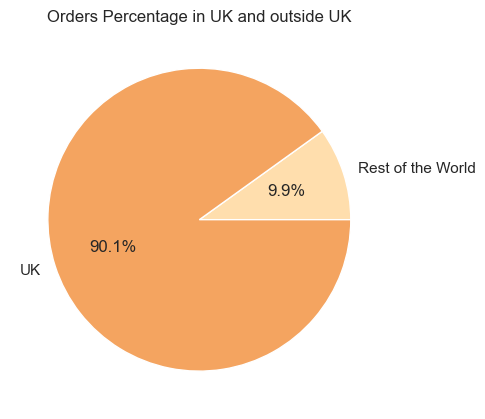

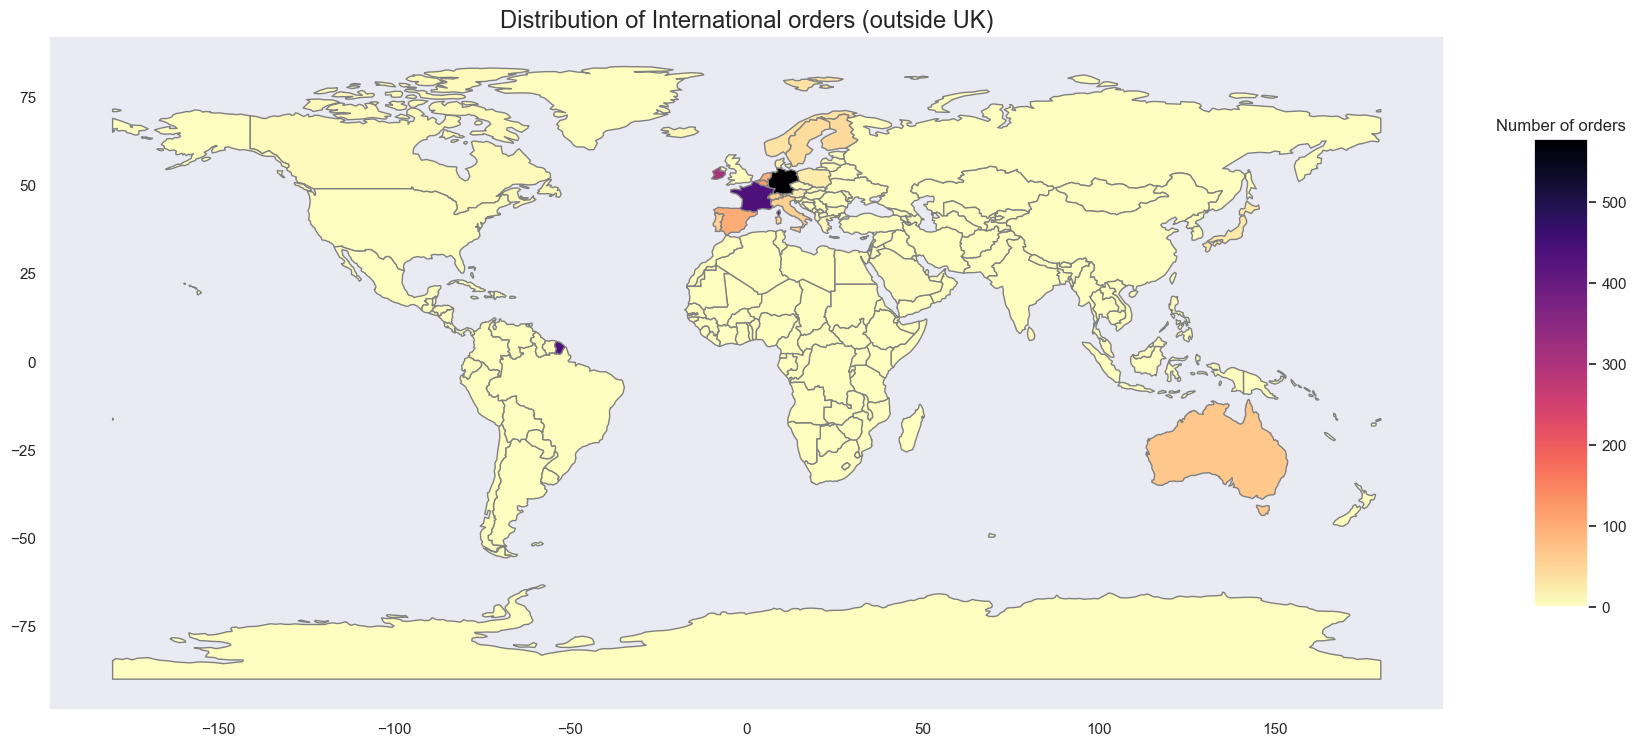

In [37]:
addToWorld(world,'InvoiceNo','TotalOrders','orders')

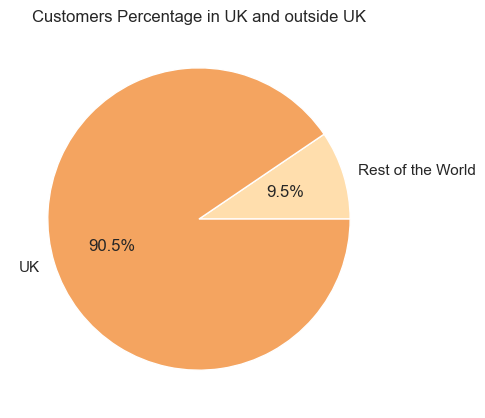

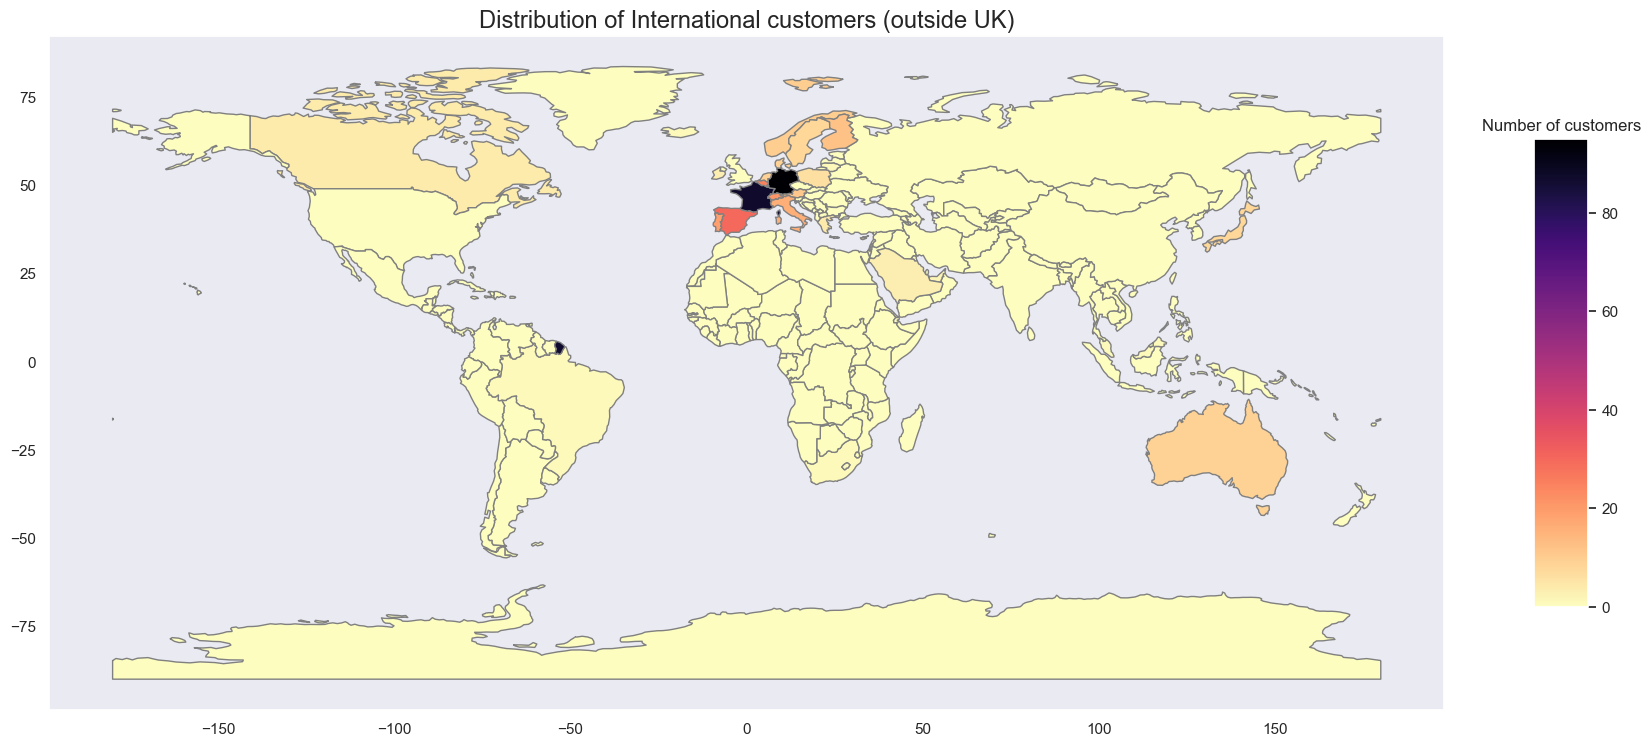

In [38]:
addToWorld(world,'CustomerID','TotalCust','customers')

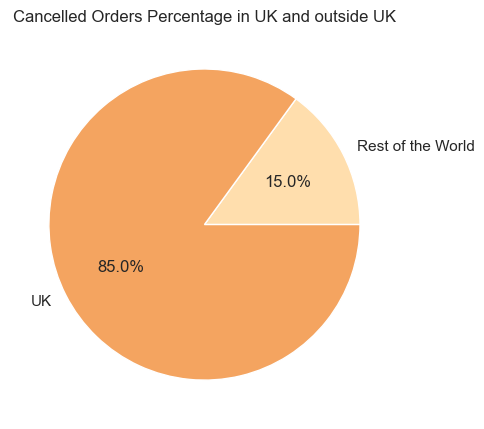

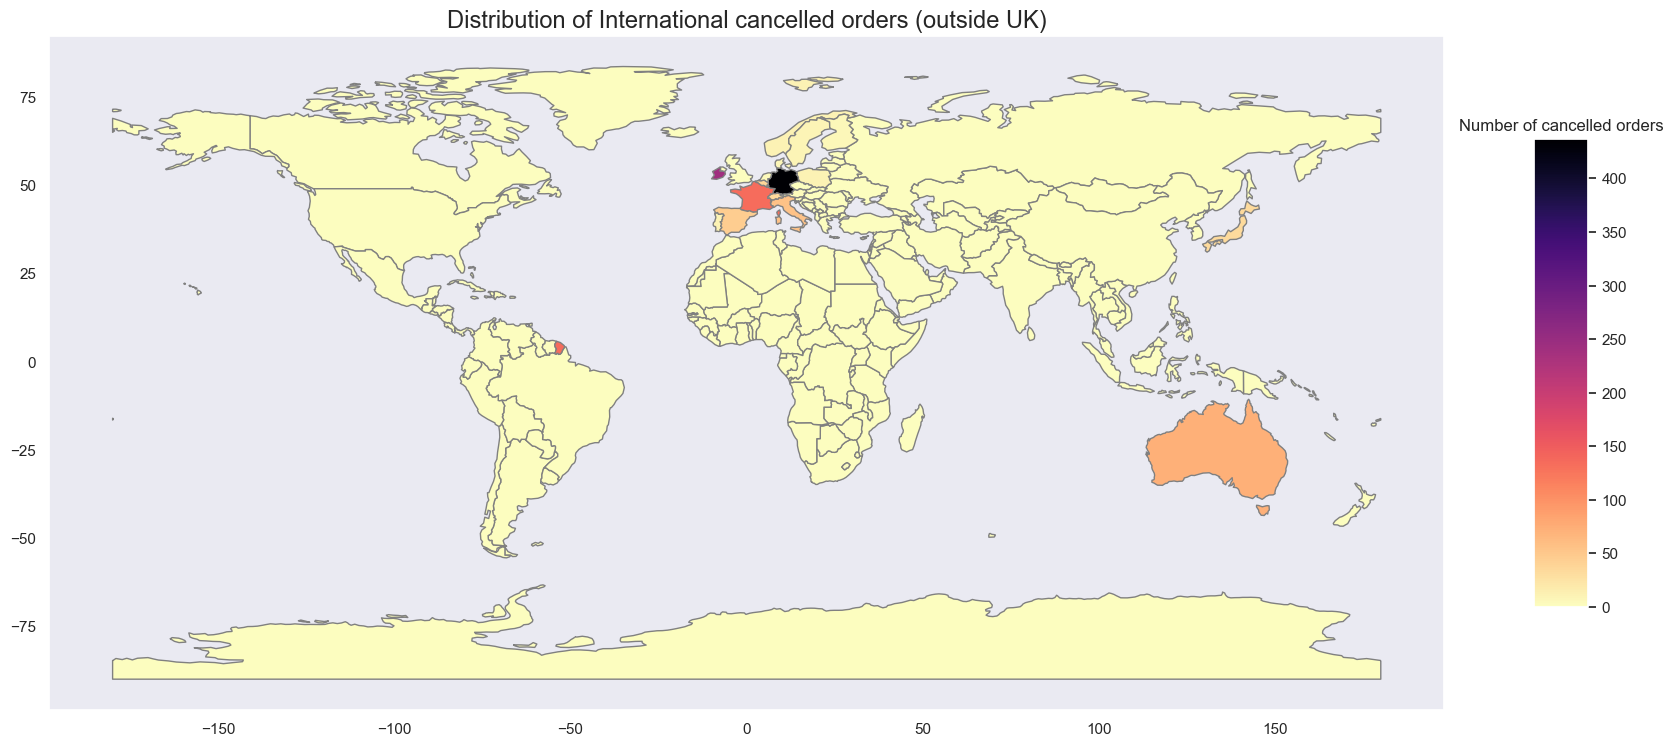

In [39]:
addToWorld(world,None,'Cancelled','cancelled orders')

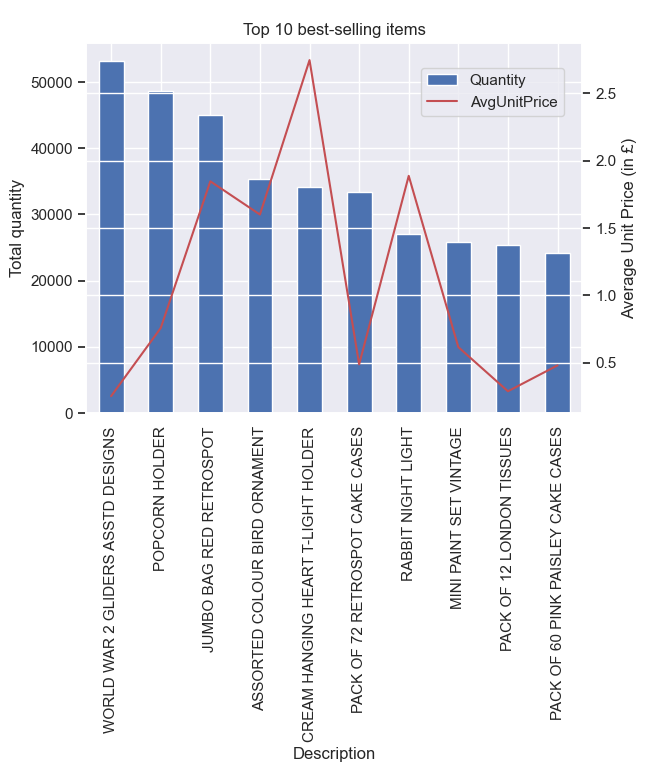

In [40]:
# Find the 10 best-selling items

Top10Qty = df.groupby('Description',as_index=False)['Quantity','TotalPrice'].sum().sort_values(by='Quantity',
                                                                                               ascending=False).head(10)
Top10Qty['AvgUnitPrice'] = Top10Qty.TotalPrice/Top10Qty.Quantity

# Plot top 10 most popular items

ax = Top10Qty.plot(x="Description", y="Quantity", legend=False,kind='bar')
ax2 = ax.twinx()
Top10Qty.plot(x="Description", y="AvgUnitPrice", ax=ax2, legend=False, color="r")
ax.figure.legend(loc=(.65,.85))
plt.title('Top 10 best-selling items')
ax.set_ylabel('Total quantity')
ax2.set_ylabel('Average Unit Price (in £)')
plt.show()

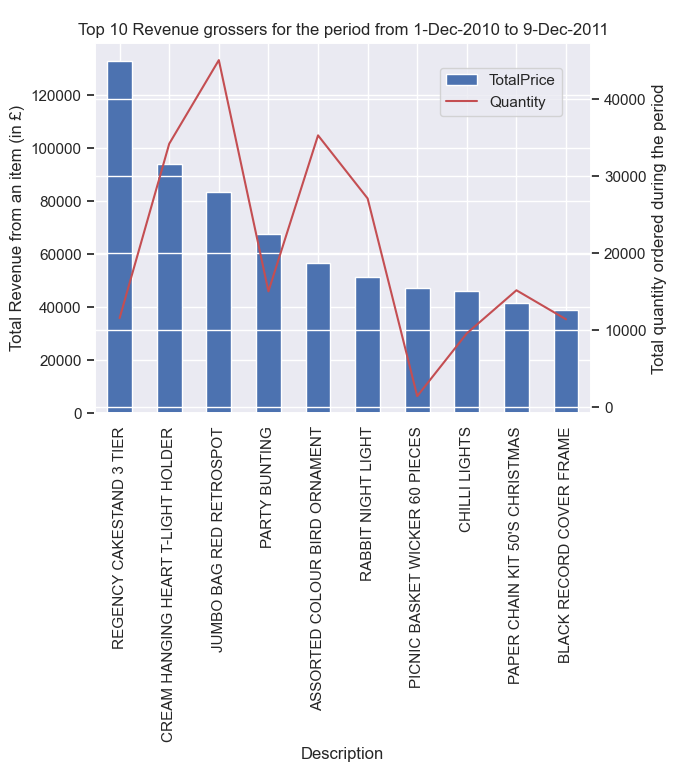

In [41]:
# Top 10 revenue grossing items

Top10Rev = df.groupby('Description',as_index=False)['TotalPrice','Quantity'].sum().sort_values(by='TotalPrice',
                                                                                               ascending=False).head(10)
Top10Rev['AvgUnitPrice'] = Top10Rev.TotalPrice/Top10Rev.Quantity

# Total Revenue
TotalRev = round(df.TotalPrice.sum(),0)

# Plot top 10 revenue grossers
ax = Top10Rev.plot(x="Description", y="TotalPrice", legend=False,kind='bar')
ax2 = ax.twinx()
Top10Rev.plot(x="Description", y="Quantity", ax=ax2, legend=False, color="r")
# ax.axhline(TotalRev, c='k', ls='--')
ax.figure.legend(loc=(.65,.85))
plt.title('Top 10 Revenue grossers for the period from 1-Dec-2010 to 9-Dec-2011')
ax.set_ylabel('Total Revenue from an item (in £)')
ax2.set_ylabel('Total quantity ordered during the period')
plt.show()

In [42]:
# Number of unique items and customers

print(len(df.Description.unique()))
print(len(df.CustomerID.unique()))

3652
4357


## Pareto Principle
The Pareto principle (also known as the 80/20 rule) states that, for many events, roughly 80% of the effects come from 20% of the causes.(Source: wikipedia)

For a sales entity, Pareto pinciple could suggest that 80% sales of a company comes from 20% of its products and/or 80% of its sales comes from 20% of its customers.

Our online retail store has 3652 unique items for sale, and 4357 unique customers for the period from Dec 1 2010 to Dec 9 2011. Here, Pareto principle is of value because instead of focussing on such a huge number of items and customers, the company needs to just focus on 20% of these in order to effect 80% of its sales.

Let us check the applicability of Pareto principle for our dataset.

In [43]:
def applyPareto(df,column_20, measure):
    '''
    Checks the contribution of 20% of a cause to 80% of sales revenue
     ----------------
    Input:
        df: dataset on which Pareto principle is to be checked
        column_20: column to be checked for 20% of its unique entries to affect 80% of sales
        measure: string - the measure that is conributing to 80%
    ----------------
    '''
    pareto_df = df.groupby(column_20,as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False)
    pareto_df['cumulative_sum'] = pareto_df.TotalPrice.cumsum()
    pareto_df['cumulative_perc'] = 100*pareto_df.cumulative_sum/pareto_df.TotalPrice.sum()
    
    item_perc = round(len(pareto_df[(pareto_df.cumulative_perc)<80])/len(pareto_df)*100)

    print(item_perc,'% of',measure,'contribute to 80% of sales')
    print(item_perc,'% means',round(item_perc/100*len(pareto_df)),measure)
    
    plotPareto(pareto_df, column_20,measure)
    
def plotPareto(pareto_df,column_20,measure):
    '''
    Displays applicability of Pareto Principle on a dataset
    '''
    # Graphical representation of Pareto Principle
    pareto_df['demarcation'] = 80
    pareto_threshold = int(len(pareto_df)*.20)


    trace1 = Bar(x=pareto_df[column_20],y=pareto_df.TotalPrice, name='Sales Revenue', marker=dict(color='rgb(34,163,192)'))
    trace2 = Scatter(
        x=pareto_df[column_20],
        y=pareto_df.cumulative_perc,
        name='Cumulative Percentage',
        yaxis='y2',
        line=dict(
            color='rgb(243,158,115)',
            width=2.4
           )
    )
    trace3 = Scatter(
        x=pareto_df[column_20],
        y=pareto_df.demarcation,
        name='80%',
        yaxis='y2',
        line=dict(
            color='rgba(128,128,128,.45)',
            dash = 'dash',
            width=1.5
           )
    )
    trace4 = Scatter(
        x=[pareto_df.head(pareto_threshold).tail(1)[column_20]],
        y=[round(max(pareto_df.TotalPrice))*.90],
        text=['20% of items'],
        mode='text',
    )

    data = [trace1, trace2, trace3, trace4]
    
    layout = Layout(title=measure+'wise sales revenue from 1-Dec-2010 to 9-Dec-2011', 
                    titlefont=dict(color='black', family='Balto, sans-serif', size=12), 
                    font=Font(color='rgb(128,128,128)', family='Balto, sans-serif', size=12), width=1500, height=623, 
                    paper_bgcolor='rgb(240, 240, 240)', plot_bgcolor='rgb(240, 240, 240)', hovermode='closest', 
                    margin=dict(b=250,l=60,r=60,t=65), showlegend=True, 
                    legend=dict(x=.83, y=1.3, font=dict(family='Balto, sans-serif', size=12, color='rgba(128,128,128,.75)'),),
                    annotations=[ dict(text="Cumulative Percentage", showarrow=False, xref="paper", yref="paper", textangle=90, 
                                       x=1.029, y=.75, font=dict(family='Balto, sans-serif', size=14, color='rgba(243,158,115,.9)'),
                                      )], 
                    shapes=[{'type':'line', 'x0':pareto_threshold,'y0':0,'x1':pareto_threshold,'y1':round(max(pareto_df.TotalPrice)),
                             'line':{'color':'rgb(128,128,128,.45)','dash':'dot','width': 1.5}}],
                    xaxis=dict(tickangle=-90), 
                    yaxis=dict(title='Sales (in £)', range=[0,round(max(pareto_df.TotalPrice))], dtick=1,
                                                          tickfont=dict(color='rgba(34,163,192,.75)'),
                                                          tickvals = np.linspace(0,max(round(pareto_df.TotalPrice)),6), 
                                                          titlefont=dict(family='Balto, sans-serif', size=14,
                                                                         color='rgba(34,163,192,.75)'),tickformat='.0f'), 
                    yaxis2=dict(range=[0,101], tickfont=dict(color='rgba(243,158,115,.9)'), tickvals = [0,20,40,60,80,100],
                                overlaying='y', side='right'))

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [44]:

applyPareto(df,'Description','items')

22 % of items contribute to 80% of sales
22 % means 803 items


Pareto principle holds true for items in our dataset, as 22% of all the items are contributing to 80% of the sales revenue. 22% of all items means 803 items.



In [45]:
applyPareto(df,'CustomerID','customers')

27 % of customers contribute to 80% of sales
27 % means 1176 customers


27% of all the customers are contributing to 80% of the sales revenue. 27% of all items means 1176 items.



#### Time Series plots


In [46]:
from matplotlib import pylab

In [47]:
sales = df.groupby('InvoiceDate')['TotalPrice'].sum()
sales.index = pd.to_datetime(sales.index)

In [48]:
def plotSales(sales,time_freq,xtick,freq):
    trend = sales.resample(time_freq).sum()
    holidays = ['2010-12-27', '2010-12-28', '2011-01-03', '2011-04-22', '2011-04-25', '2011-04-29', '2011-05-02',
            '2011-05-30', '2011-08-29']

    fig = plt.figure(figsize=(20, 5))

    plt.plot(trend)

    dates = trend.index[::xtick]
    labels = dates.strftime('%b %d %H:%M %A')
    
    if time_freq!='H':
        [pylab.axvline(_x, linewidth=1, color='r',ls='--') for _x in holidays]
        labels = dates.strftime('%b %d')

    plt.xticks(dates, labels, rotation=90)
    plt.legend(['TotalPrice','UK Holidays'])
    plt.title(freq+' sales from Dec-1-2010 to Dec-09-2011')
    plt.show()

ConversionError: Failed to convert value(s) to axis units: '2010-12-27'

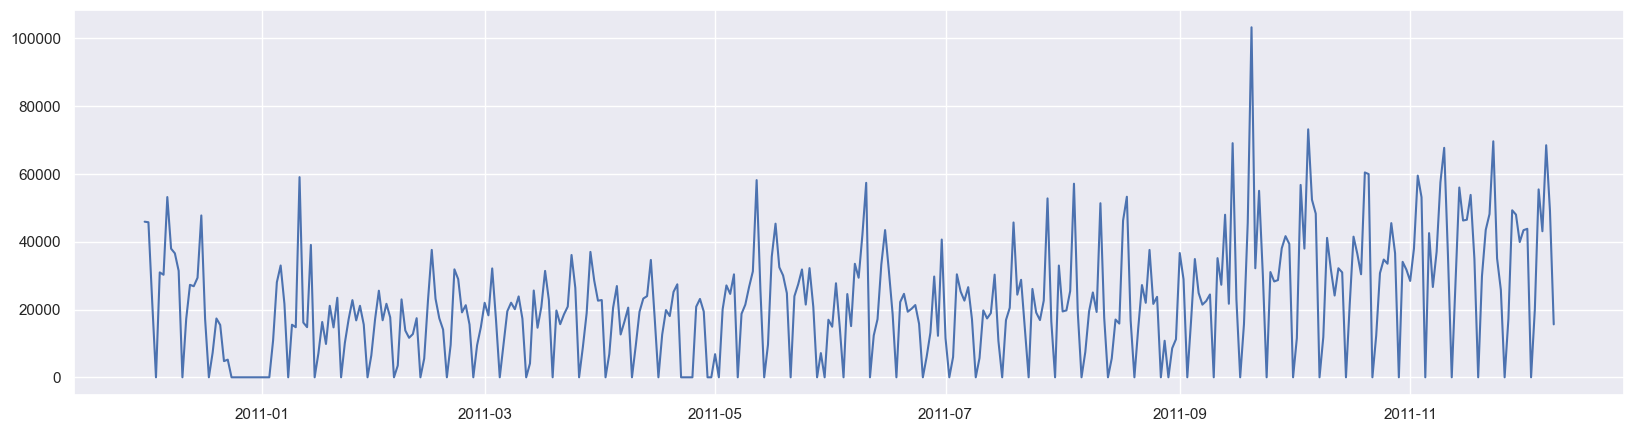

In [51]:
# Example usage with some dummy sales data
#sales = pd.Series(np.random.randint(0, 100, size=365), index=pd.date_range('2010-12-01', periods=365, freq='D'))
plotSales(sales, 'D', 4, 'Daily')


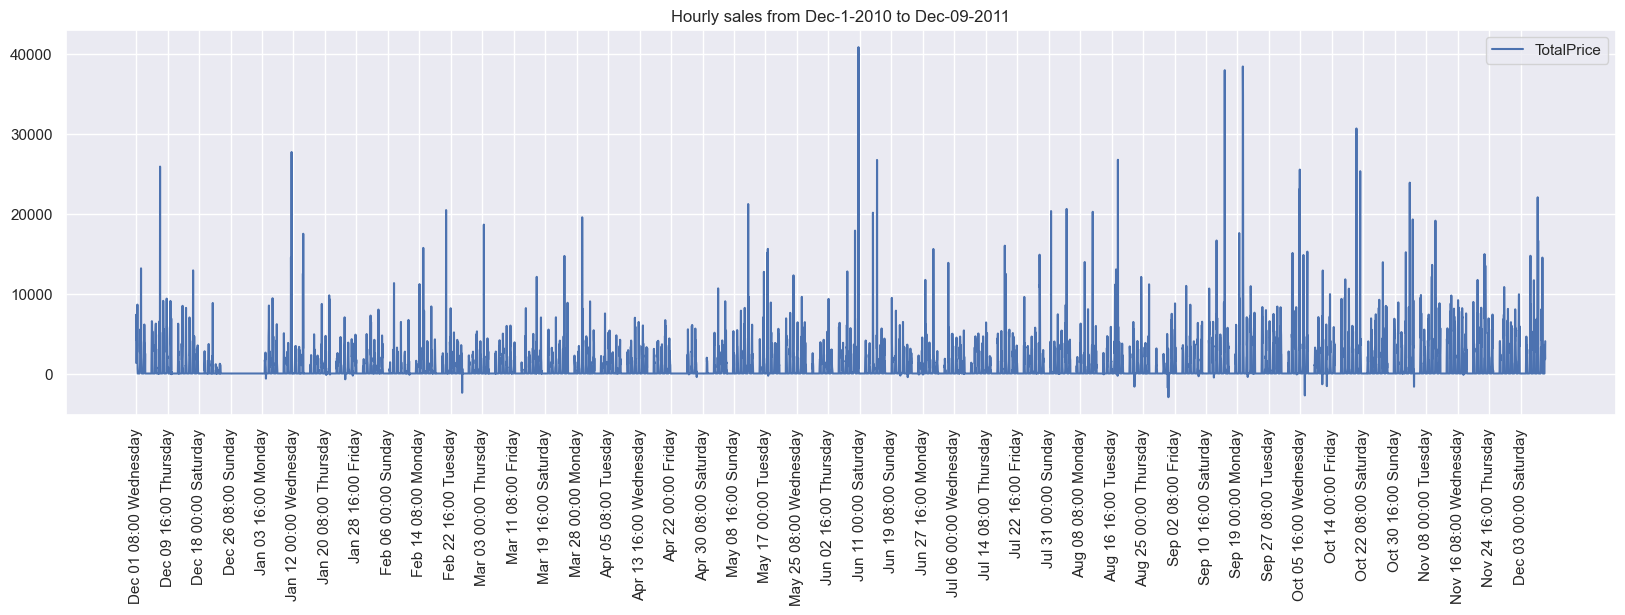

In [54]:
plotSales(sales, 'H', 200, 'Hourly')


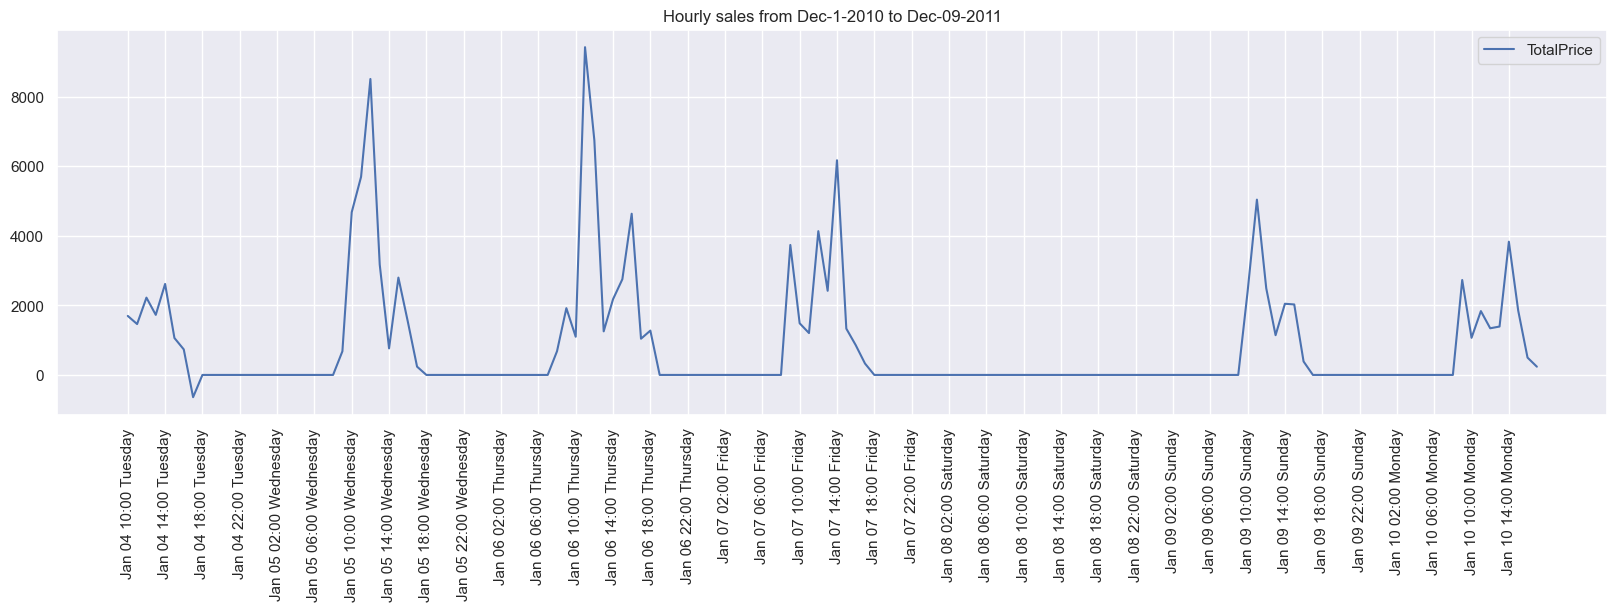

In [55]:
plotSales(sales['2011-01-01':'2011-01-10'],'H',4,'Hourly')

ConversionError: Failed to convert value(s) to axis units: '2010-12-27'

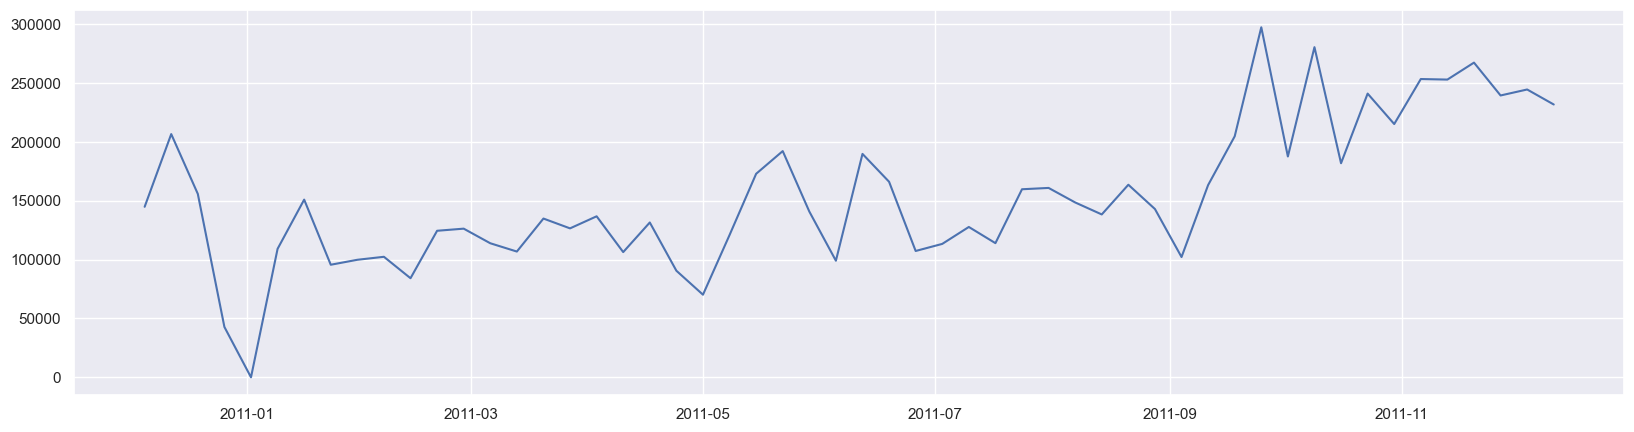

In [56]:
plotSales(sales,'W',1,'Weekly')

ConversionError: Failed to convert value(s) to axis units: '2010-12-27'

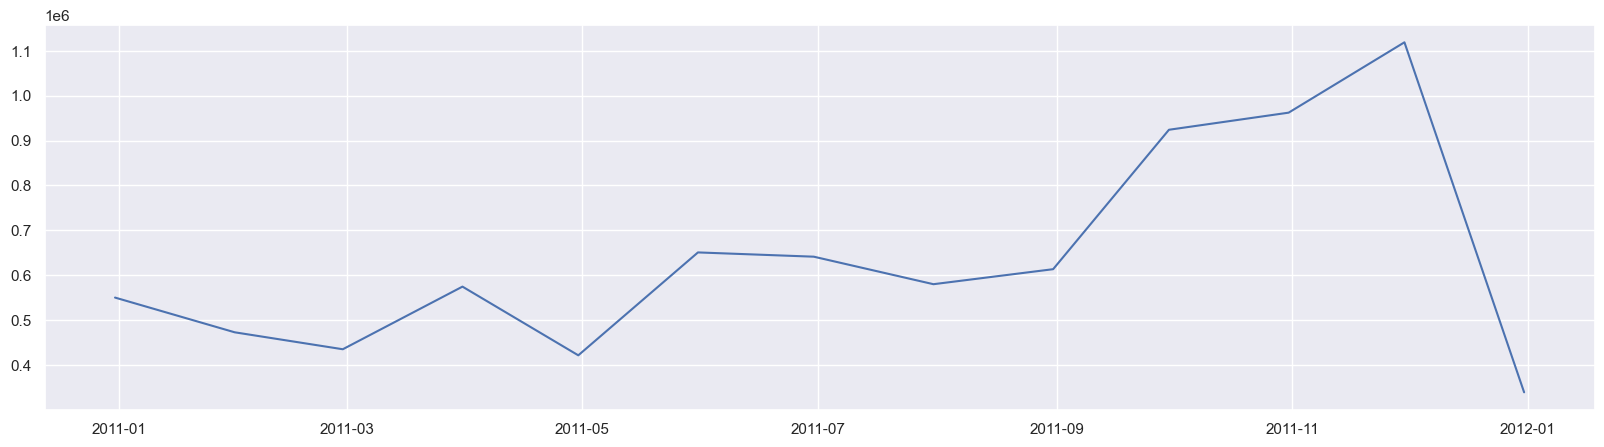

In [57]:
plotSales(sales,'M',1,'Monthly')

ConversionError: Failed to convert value(s) to axis units: '2010-12-27'

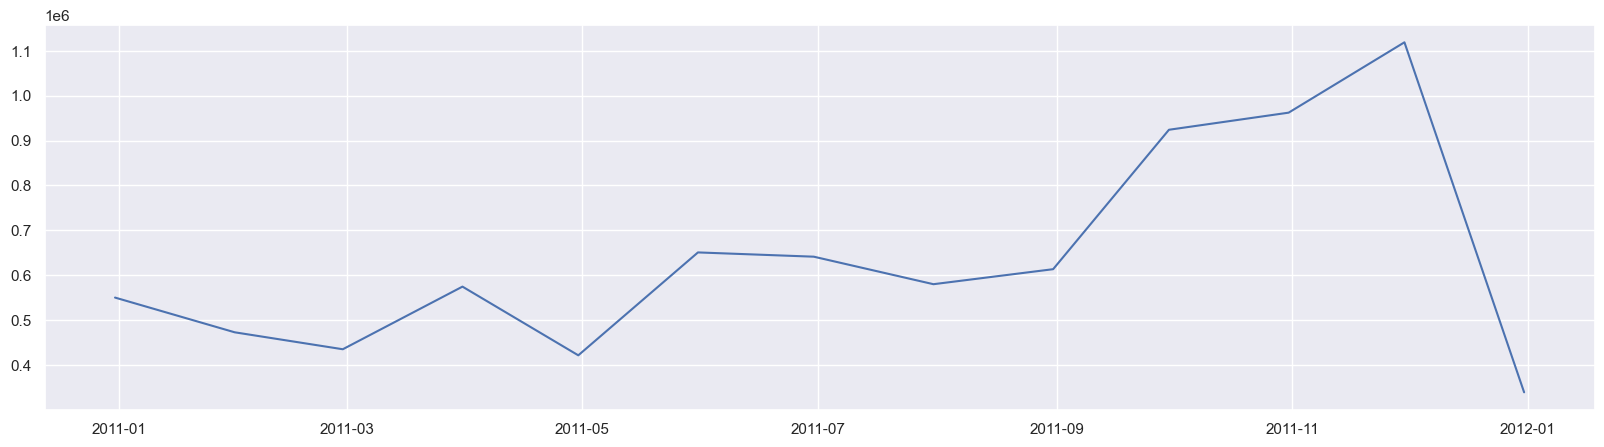

In [58]:
plotSales(sales,'M',1,'Monthly')

### Observations

1.There is no sales happening on Saturdays.

2.Sales falls down during the holidays

3.There is zero sales happening on Boxing day (Dec 26th) which probably means that the company does not offer any promotions during the holidays/special days.

4.Sales happens only during the working hours - between 8am and 6pm.

5.There is no particular trend seen in monthly and weekly sales. The overall sales has increased through the months.


In [59]:
df.to_csv('orders.csv')

In [60]:
# Load dataset
orders = pd.read_csv('orders.csv').drop(['Unnamed: 0'],axis=1)
orders.head()

InvoiceNo StockCode  Quantity          InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6  2010-12-01 08:26:00       2.55     C17850   
1    536365     71053         6  2010-12-01 08:26:00       3.39     C17850   
2    536365    84406B         8  2010-12-01 08:26:00       2.75     C17850   
3    536365    84029G         6  2010-12-01 08:26:00       3.39     C17850   
4    536365    84029E         6  2010-12-01 08:26:00       3.39     C17850   

          Country                          Description  CancelledOrder  \
0  United Kingdom   CREAM HANGING HEART T-LIGHT HOLDER               0   
1  United Kingdom                  WHITE METAL LANTERN               0   
2  United Kingdom       CREAM CUPID HEARTS COAT HANGER               0   
3  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE               0   
4  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.               0   

   InternationalOrders  TotalPrice  
0                    0       15.30  
1                    0       20.34  
2                    0       22.00  
3                    0       20.34  
4                    0       20.34

In [61]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404618 entries, 0 to 404617
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   InvoiceNo            404618 non-null  object 
 1   StockCode            404618 non-null  object 
 2   Quantity             404618 non-null  int64  
 3   InvoiceDate          404618 non-null  object 
 4   UnitPrice            404618 non-null  float64
 5   CustomerID           404618 non-null  object 
 6   Country              404618 non-null  object 
 7   Description          404618 non-null  object 
 8   CancelledOrder       404618 non-null  int64  
 9   InternationalOrders  404618 non-null  int64  
 10  TotalPrice           404618 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 34.0+ MB


In [62]:
# Convert InvoiceDate to datetime object
orders.InvoiceDate = pd.to_datetime(orders.InvoiceDate)

# Truncate the minutes part of datetime object
orders['InvoiceDate'] = orders.InvoiceDate.dt.date


In [63]:
# Confirm all cancelled orders have negative TotalPrice and Quantity

print(orders[(orders.InvoiceNo.str.startswith('C')) & (orders.TotalPrice>0)])
print(orders[(orders.InvoiceNo.str.startswith('C')) & (orders.Quantity>0)])

Empty DataFrame
Columns: [InvoiceNo, StockCode, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Description, CancelledOrder, InternationalOrders, TotalPrice]
Index: []
Empty DataFrame
Columns: [InvoiceNo, StockCode, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Description, CancelledOrder, InternationalOrders, TotalPrice]
Index: []


## We will drop following columns:

1.InvoiceNo and CustomerID: As we have to predict itemwise sales, we don't need these columns

2.Country, InternationalOrders: We are not making distinction between international or domestic sales in the predictions, so we don't need this column

3.Description: We have the StockCode, so this is repetitive

4.CancelledOrder: Cancelled orders have negative quantity and price. So while aggregating the dataset, cancellations will be taken into account. We don't need this column.

5.UnitPrice: In our dataset, same item has different prices. So we will keep TotalPrice and drop UnitPrice. While aggregating we will calculate the UnitPrice from TotalPrice and Quantity for each item and month again.


In [64]:
orders.drop(['InvoiceNo', 'CustomerID','Country','InternationalOrders','Description','CancelledOrder','UnitPrice'],
            axis=1,inplace=True)


## Feature Engineering


In [65]:
orders.head()

StockCode  Quantity InvoiceDate  TotalPrice
0    85123A         6  2010-12-01       15.30
1     71053         6  2010-12-01       20.34
2    84406B         8  2010-12-01       22.00
3    84029G         6  2010-12-01       20.34
4    84029E         6  2010-12-01       20.34

In [66]:
orders = orders.groupby(['InvoiceDate','StockCode'],as_index=False).sum()
orders.InvoiceDate = pd.to_datetime(orders.InvoiceDate)


In [67]:
orders['Year'] = orders.InvoiceDate.dt.year
orders['Quarter'] = orders.InvoiceDate.dt.quarter
orders['Month'] = orders.InvoiceDate.dt.month
orders['Week'] = orders.InvoiceDate.dt.week
orders['Weekday'] = orders.InvoiceDate.dt.weekday
orders['Day'] = orders.InvoiceDate.dt.day
orders['Dayofyear'] = orders.InvoiceDate.dt.dayofyear
orders['UnitPrice'] = orders.TotalPrice/orders.Quantity

In [68]:
orders.head()

InvoiceDate StockCode  Quantity  TotalPrice  Year  Quarter  Month  Week  \
0  2010-12-01     10002        60       51.00  2010        4     12    48   
1  2010-12-01     10125         2        1.70  2010        4     12    48   
2  2010-12-01     10133         5        4.25  2010        4     12    48   
3  2010-12-01    15044B         1        2.95  2010        4     12    48   
4  2010-12-01   15056BL        20      113.00  2010        4     12    48   

   Weekday  Day  Dayofyear  UnitPrice  
0        2    1        335       0.85  
1        2    1        335       0.85  
2        2    1        335       0.85  
3        2    1        335       2.95  
4        2    1        335       5.65

In [69]:
orders.describe().T

count         mean         std      min      25%          50%  \
Quantity    224628.0    21.755712   65.986694 -8974.00     3.00     8.000000   
TotalPrice  224628.0    36.874346  136.945165 -3825.36     6.25    15.300000   
Year        224628.0  2010.936713    0.243479  2010.00  2011.00  2011.000000   
Quarter     224628.0     2.739730    1.130302     1.00     2.00     3.000000   
Month       224628.0     7.253993    3.448225     1.00     4.00     8.000000   
Week        224628.0    29.413662   14.901138     1.00    16.00    32.000000   
Weekday     224628.0     2.617821    1.931312     0.00     1.00     2.000000   
Day         224628.0    15.114460    8.647994     1.00     7.00    15.000000   
Dayofyear   224628.0   204.576740  104.412414     4.00   111.00   220.000000   
UnitPrice   224087.0          NaN         NaN     -inf     0.85     1.663433   

                75%      max  
Quantity      24.00   4848.0  
TotalPrice    33.00  39619.5  
Year        2011.00   2011.0  
Quarter        4.00      4.0  
Month         10.00     12.0  
Week          43.00     51.0  
Weekday        4.00      6.0  
Day           22.00     31.0  
Dayofyear    299.00    357.0  
UnitPrice      3.75      inf

In [70]:
# Drop rows with negative Quantity

orders = orders.drop(orders[orders.Quantity<=0].index).reset_index(drop=True)
orders = orders.drop(orders[orders.TotalPrice<=0].index).reset_index(drop=True)

# Removing outliers in Quantity and TotalPrice
orders = orders[(np.abs(stats.zscore(orders.Quantity)) < 3)]
orders = orders[(np.abs(stats.zscore(orders.TotalPrice)) < 3)]

In [71]:
orders.describe().T

count         mean         std      min      25%      50%  \
Quantity    216753.0    17.320586   25.659530     1.00     3.00     8.00   
TotalPrice  216753.0    29.372231   42.252063     0.06     6.64    15.30   
Year        216753.0  2010.937057    0.242860  2010.00  2011.00  2011.00   
Quarter     216753.0     2.738772    1.130421     1.00     2.00     3.00   
Month       216753.0     7.251461    3.447829     1.00     4.00     8.00   
Week        216753.0    29.402726   14.900267     1.00    16.00    32.00   
Weekday     216753.0     2.630510    1.942232     0.00     1.00     2.00   
Day         216753.0    15.127034    8.651776     1.00     7.00    15.00   
Dayofyear   216753.0   204.512533  104.410938     4.00   111.00   220.00   
UnitPrice   216753.0     2.885342    4.465393     0.04     0.85     1.65   

                75%      max  
Quantity      23.00   211.00  
TotalPrice    31.60   343.05  
Year        2011.00  2011.00  
Quarter        4.00     4.00  
Month         10.00    12.00  
Week          43.00    51.00  
Weekday        4.00     6.00  
Day           22.00    31.00  
Dayofyear    299.00   357.00  
UnitPrice      3.75   295.00

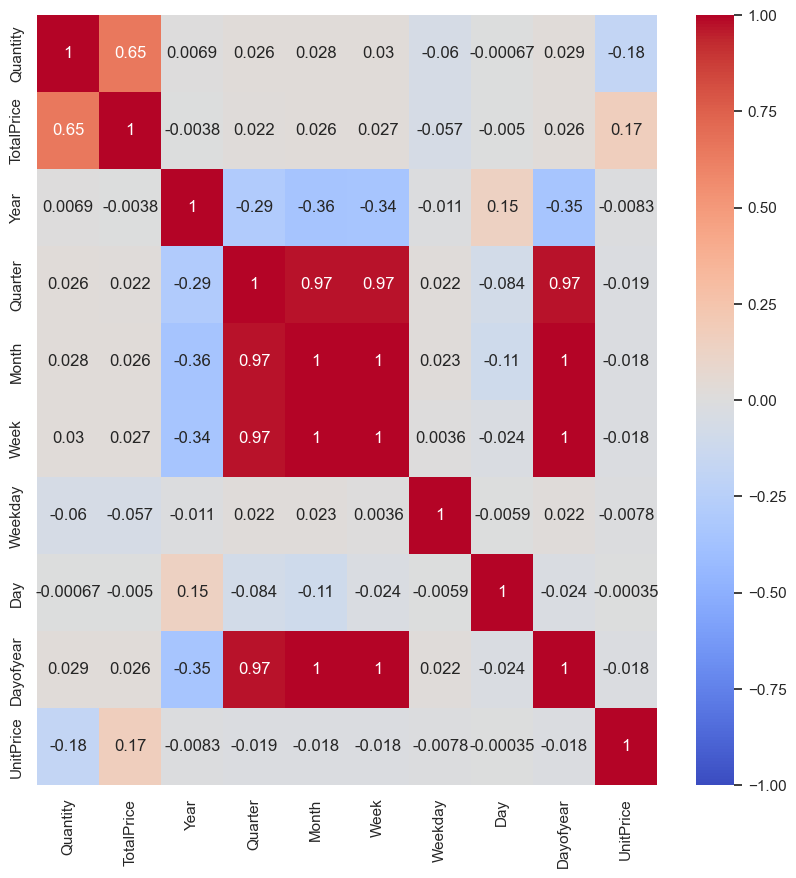

In [72]:
# Get correlations of each features in dataset
corrmat = orders.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# Plot heat map
g=sns.heatmap(orders[top_corr_features].corr(),annot=True,cmap="coolwarm",vmin=-1,vmax=1,center=0)

#### Above heatmap shows strong correlation between Quarter, Month, Dayofyear and Week. We will drop , Dayofyear, quarter and month, and just keep week, as week is most strongly correlated with week. Year has strong correlation with Day, and as it is not strongly correlated with Quantity, we will drop it.


In [73]:
orders.drop(['Month', 'Quarter','Dayofyear','Year'], axis=1,inplace=True)

In [74]:
orders.head()

InvoiceDate StockCode  Quantity  TotalPrice  Week  Weekday  Day  UnitPrice
0  2010-12-01     10002        60       51.00    48        2    1       0.85
1  2010-12-01     10125         2        1.70    48        2    1       0.85
2  2010-12-01     10133         5        4.25    48        2    1       0.85
3  2010-12-01    15044B         1        2.95    48        2    1       2.95
4  2010-12-01   15056BL        20      113.00    48        2    1       5.65

In [75]:
orders.to_csv('afterordersdata.csv')

## Machine Learning

In [76]:
# Read the previous csv file as dataframe
mldf = pd.read_csv('afterordersdata.csv').drop(['Unnamed: 0'],axis=1)
mldf.head()

InvoiceDate StockCode  Quantity  TotalPrice  Week  Weekday  Day  UnitPrice
0  2010-12-01     10002        60       51.00    48        2    1       0.85
1  2010-12-01     10125         2        1.70    48        2    1       0.85
2  2010-12-01     10133         5        4.25    48        2    1       0.85
3  2010-12-01    15044B         1        2.95    48        2    1       2.95
4  2010-12-01   15056BL        20      113.00    48        2    1       5.65

Our final dataset is ready to carry out machine learning operations.

### Machine Learning Process and Methodology

To find the best model for our purpose, we will train our data on different algorithms, compare their performance based on the Root mean square error of the prediction and time taken to fit/predict the model, and select the best.

Algorithms employed:

1.Linear Regression

2.Regularization Model - Ridge

3.Regularization Model - Lasso

4.Ensemble Model - Random Forest

5.Ensemble Model - Gradient Boost

6.Ensemble Model - Ada Boost

After training and evaluating our data on the above algorithms, we will also use model stacking.

7.Stack - Linear Regression

8.Stack - Random Forest

9.Stack - Gradient Boost

# Train-test split

We will hold out the data for last month from Nov-01-2011 to Dec-09-2011 as our test set, and the remaining data will be used to train our model.

In [77]:
# Split the dataset into train and test dataset

df_train = mldf[mldf.InvoiceDate<'2011-11-01']
df_test = mldf[mldf.InvoiceDate>='2011-11-01']

In [78]:
df_train.head()

InvoiceDate StockCode  Quantity  TotalPrice  Week  Weekday  Day  UnitPrice
0  2010-12-01     10002        60       51.00    48        2    1       0.85
1  2010-12-01     10125         2        1.70    48        2    1       0.85
2  2010-12-01     10133         5        4.25    48        2    1       0.85
3  2010-12-01    15044B         1        2.95    48        2    1       2.95
4  2010-12-01   15056BL        20      113.00    48        2    1       5.65

In [79]:
# Define the feature and target variables

X_train = df_train.drop(labels=['InvoiceDate','StockCode','Quantity','TotalPrice'],axis=1)
y_train = df_train.Quantity

X_test = df_test.drop(labels=['InvoiceDate','StockCode','Quantity','TotalPrice'],axis=1)
y_test = df_test.Quantity

In [80]:
# Data Frame to store all the RMSE scores for various algorithms
algo_score = pd.DataFrame()
algo_score.index.name = 'Modelling Algo'
algo_score['Train RMSE'] = None
algo_score['Test RMSE'] = None
algo_score['Hyperparameters'] = None
algo_score['Training+Test Time(sec)'] = None

cv_time = []

# Dataframes for second level of predictions. Collect the predicted y values for training and test set of data
ypred_train = pd.DataFrame(index = X_train.index)
ypred_test = pd.DataFrame(index = X_test.index)

ypred_train['quantity'], ypred_test['quantity'] = y_train, y_test

We will define functions to measure the model, apply cross validation, and predict on train and test datasets. We have not included model fitting in the functions as that will happen as part of hyperparameter tuning



In [81]:
from sklearn.metrics import make_scorer

# Metric used to measure the model (Root Mean Square Error)
def rmse(y_actual, y_pred):
    rmse = np.sqrt(mean_squared_error(y_actual,y_pred))
    return rmse
rmse_cv = make_scorer(rmse, greater_is_better=False)


plot_true_vs_pred: This is used to plot True and Predicted count values for a particular time interval


In [82]:
# Plots True vs. Predicted count values
def plot_true_vs_pred (y_actual, y_pred):
    fig = plt.figure(figsize=(18, 16))
    
    pred_val = pd.DataFrame({'actual':y_actual,'predicted':y_pred})
    pred_val['error']=abs(pred_val.actual-pred_val.predicted)
    sns.swarmplot(pred_val.actual.round(0),pred_val.error)
    
    plt.show()

In [83]:
# Function to predict on train and test data and return the required metrics
def model_fit(model, X_train, y_train, X_test, y_test):
    ''' 
    Input:
        model = model to be applied
        X_train y_train = Training data
        X_test, y_test = Testing data
    Output:
        rmse for training and test data 
        predicted y for training and test data
    
    '''
#     model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    rmse_train = rmse(y_train, y_train_predict)
    rmse_test = rmse(y_test, y_test_predict)
    
    rmse_all = [rmse_train, rmse_test]
    y_pred_all = [y_train_predict, y_test_predict]
    
    return(rmse_all, y_pred_all)

In [84]:
from sklearn.model_selection import cross_val_predict
def cross_val(model, X_train, y_train, cv=5):
#     y_pred = pd.Series(index=y_train.index)
    y_pred = cross_val_predict(model,X_train,y_train,cv=5)

    rmse_train = rmse(y_train,y_pred)
    return(rmse_train, y_pred)

# Linear Regression


In [85]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

param_summary = ['','']

%time reg.fit(X_train, y_train)
%time rmse_summary, y_predict_summary = model_fit(reg, X_train, y_train, X_test, y_test)

ypred_test['LR'] = y_predict_summary[1]  
ypred_train['LR'] = y_predict_summary[0]

algo_score.loc['Linear Regression'] = rmse_summary+param_summary


CPU times: total: 46.9 ms
Wall time: 48 ms
CPU times: total: 15.6 ms
Wall time: 12.1 ms


In [86]:
algo_score.loc['Linear Regression', 'Training+Test Time(sec)'] = 0.516
cv_time.append(0.516)
algo_score

Train RMSE  Test RMSE Hyperparameters  \
Modelling Algo                                             
Linear Regression   25.033909  25.931982                   

                  Training+Test Time(sec)  
Modelling Algo                             
Linear Regression                   0.516

Observations

Not an overfit model - both train and test RMSE are more or less similar

In [87]:
# Features and the Estimated Linear Regression Coefficients
df_coeff = pd.DataFrame({'features': X_train.columns, 'Lin_Coeff': reg.coef_})


In [88]:
# Linear Regression Plot: True vs. Predicted
# plot_true_vs_pred(y_test,y_predict_summary[1])

Regularization Model - Ridge


In [89]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning
param_grid = {'alpha': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]}
ridge = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring=rmse_cv)
%time ridge.fit(X_train, y_train)
print('Best alpha for Ridge Regression Model: {}'.format(ridge.best_params_))

CPU times: total: 1.25 s
Wall time: 1.27 s
Best alpha for Ridge Regression Model: {'alpha': 100}


In [90]:
# Fine tune Hyperparameter for edge cases
param_grid = {'alpha': np.arange(75,150,10)}
ridge = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring=rmse_cv)
%time ridge.fit(X_train, y_train)
print('Best alpha for Ridge Regression Model: {}'.format(ridge.best_params_))

CPU times: total: 984 ms
Wall time: 984 ms
Best alpha for Ridge Regression Model: {'alpha': 145}


In [91]:
param_summary = [ridge.best_params_,'']

%time rmse_summary, y_predict_summary = model_fit(ridge, X_train, y_train, X_test, y_test)

ypred_test['Ridge'] = y_predict_summary[1]  
ypred_train['Ridge'] = y_predict_summary[0]

algo_score.loc['Ridge Regression'] = rmse_summary+param_summary

CPU times: total: 15.6 ms
Wall time: 15 ms


In [92]:
algo_score.loc['Ridge Regression', 'Training+Test Time(sec)'] = 6.917
cv_time.append(6.917)
algo_score

Train RMSE  Test RMSE Hyperparameters  \
Modelling Algo                                             
Linear Regression   25.033909  25.931982                   
Ridge Regression    25.033909  25.931989  {'alpha': 145}   

                  Training+Test Time(sec)  
Modelling Algo                             
Linear Regression                   0.516  
Ridge Regression                    6.917

Observations

Ridge gives almost similar performance as Linear Regression. It is not an overfit model

In [93]:
# Features and the Estimated Ridge Regression Coefficients
df_coeff['Ridge_Coeff'] = ridge.best_estimator_.coef_


In [94]:
# plot_true_vs_pred(y_test,y_predict_summary[1])

# Regularization Model - Lasso

In [95]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning
param_grid = {'alpha': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]}
lasso = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring=rmse_cv)
%time lasso.fit(X_train, y_train)
print('Best alpha for Lasso Regression Model: {}'.format(lasso.best_params_))

CPU times: total: 1.78 s
Wall time: 1.6 s
Best alpha for Lasso Regression Model: {'alpha': 0.2}


In [96]:
# Fine tune Hyperparameter for edge case

param_grid = {'alpha': np.arange(.01,.25,.01)}
lasso = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring=rmse_cv)
%time lasso.fit(X_train, y_train)
print('Best alpha for Lasso Regression Model: {}'.format(lasso.best_params_))


CPU times: total: 4.47 s
Wall time: 3.9 s
Best alpha for Lasso Regression Model: {'alpha': 0.22}


In [97]:
param_summary = [lasso.best_params_,'']

%time rmse_summary, y_predict_summary = model_fit(lasso, X_train, y_train, X_test, y_test)
ypred_test['Lasso'] = y_predict_summary[1]
ypred_train['Lasso'] = y_predict_summary[0]

algo_score.loc['Lasso Regression'] = rmse_summary+param_summary

CPU times: total: 15.6 ms
Wall time: 16 ms


In [98]:
algo_score.loc['Lasso Regression', 'Training+Test Time(sec)'] = 31.328
cv_time.append(31.328)
algo_score

Train RMSE  Test RMSE  Hyperparameters  \
Modelling Algo                                              
Linear Regression   25.033909  25.931982                    
Ridge Regression    25.033909  25.931989   {'alpha': 145}   
Lasso Regression    25.034230  25.933011  {'alpha': 0.22}   

                  Training+Test Time(sec)  
Modelling Algo                             
Linear Regression                   0.516  
Ridge Regression                    6.917  
Lasso Regression                   31.328

Observations

Lasso regression also shows almost similar performance as Linear and Ridge regression

In [99]:
# Features and the Estimated Lasso Regression Coefficients
df_coeff['Lasso_Coeff'] = lasso.best_estimator_.coef_

In [100]:
# plot_true_vs_pred(y_test,y_predict_summary[1])

# Plotting the coefficients obtained from Linear, Ridge and Lasso regression


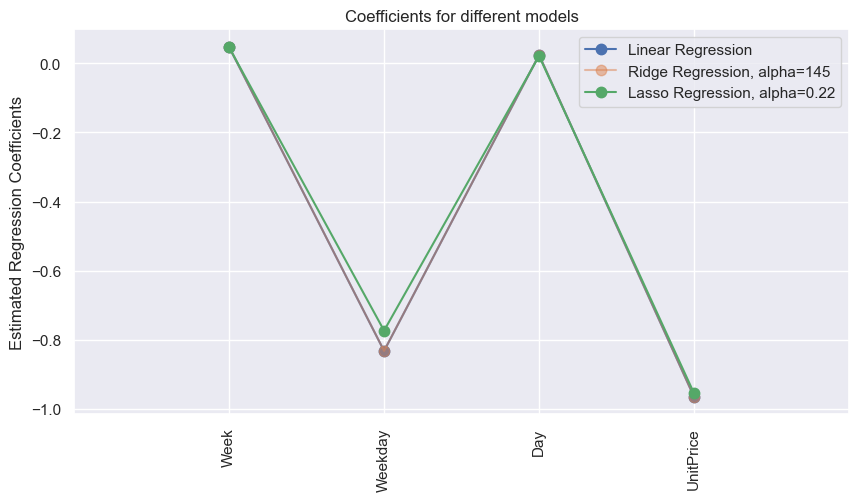

In [101]:
fig = plt.figure(figsize=(10, 5))

axes = fig.add_subplot(1, 1, 1)
axes.plot(df_coeff.Lin_Coeff, label='Linear Regression', marker='.', markersize=15)
axes.plot(df_coeff.Ridge_Coeff, label='Ridge Regression, alpha={}'.format(ridge.best_params_['alpha']), alpha=.5,marker='.', markersize=15)
axes.plot(df_coeff.Lasso_Coeff, label='Lasso Regression, alpha={}'.format(lasso.best_params_['alpha']), marker='.', markersize=15)

plt.xticks(range(len(df_coeff.Lin_Coeff)), df_coeff.features, rotation=90)
axes.set(ylabel='Estimated Regression Coefficients', title='Coefficients for different models')
axes.set(xlim=[-1, len(df_coeff.Lin_Coeff)])
axes.legend()

Observations

As seen above, Weekday and UnitPrice are most important features



# Ensemble Model - Random Forest

In [102]:
# Random Forest Regression Hyperparameter tuning using Grid Search to obtain the best parameters. 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [103]:
# The code for hyperparameter tuning is commented out as it takes a long time to run 

# Tuning the hyperparameters

param_distributions = {'n_estimators': [50,500,1000], 'max_features':['auto'], 'min_samples_leaf':[1,10,50],'n_jobs':[-1]}
rf_main = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions, verbose=2, n_iter = 50,cv=5, 
                              scoring=rmse_cv)
%time rf_main.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50, n_jobs=-1; total time=   7.4s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50, n_jobs=-1; total time=   4.8s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50, n_jobs=-1; total time=   4.6s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50, n_jobs=-1; total time=   4.7s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50, n_jobs=-1; total time=   4.7s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500, n_jobs=-1; total time=  43.4s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500, n_jobs=-1; total time=  45.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500, n_jobs=-1; total time=  44.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500, n_jobs=-1; total time=  43.4s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500, n_jobs=-1; tota

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50,
                   param_distributions={'max_features': ['auto'],
                                        'min_samples_leaf': [1, 10, 50],
                                        'n_estimators': [50, 500, 1000],
                                        'n_jobs': [-1]},
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=2)

In [104]:
print('Best parameters for Random Forest Regression Model: {}'.format(rf_main.best_params_))

Best parameters for Random Forest Regression Model: {'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 50, 'max_features': 'auto'}


In [105]:
param_summary = [rf_main.best_params_,'']

%time rmse_summary, y_predict_summary = model_fit(rf_main, X_train, y_train, X_test, y_test)
ypred_test['RF'] = y_predict_summary[1]
ypred_train['RF'] = y_predict_summary[0]

algo_score.loc['Random Forest'] = rmse_summary+param_summary

CPU times: total: 15 s
Wall time: 4.6 s


In [106]:
algo_score.loc['Random Forest', 'Training+Test Time(sec)'] = 6706
cv_time.append(6706)
algo_score


Train RMSE  Test RMSE  \
Modelling Algo                             
Linear Regression   25.033909  25.931982   
Ridge Regression    25.033909  25.931989   
Lasso Regression    25.034230  25.933011   
Random Forest       19.004094  22.758548   

                                                     Hyperparameters  \
Modelling Algo                                                         
Linear Regression                                                      
Ridge Regression                                      {'alpha': 145}   
Lasso Regression                                     {'alpha': 0.22}   
Random Forest      {'n_jobs': -1, 'n_estimators': 500, 'min_sampl...   

                  Training+Test Time(sec)  
Modelling Algo                             
Linear Regression                   0.516  
Ridge Regression                    6.917  
Lasso Regression                   31.328  
Random Forest                        6706

## Visualize the mean score against different values for n estimators

Parts of code have been commenting out as they take long time to execute


In [107]:
rf_result=pd.DataFrame(rf_main.cv_results_)
rf_result

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_jobs  \
0       5.175218      1.122668         0.168527        0.034329           -1   
1      43.286494      0.700337         0.966335        0.076993           -1   
2      95.811190      8.573630         2.311846        0.466913           -1   
3       4.491322      0.292846         0.150059        0.038464           -1   
4      40.126666      2.329207         0.809585        0.039748           -1   
5      88.517269      8.732776         1.789716        0.299087           -1   
6       4.113345      0.282327         0.148419        0.030182           -1   
7      42.539496      2.627787         0.783206        0.098701           -1   
8      75.768411      3.785431         1.357217        0.050379           -1   

  param_n_estimators param_min_samples_leaf param_max_features  \
0                 50                      1               auto   
1                500                      1               auto   
2               1000                      1               auto   
3                 50                     10               auto   
4                500                     10               auto   
5               1000                     10               auto   
6                 50                     50               auto   
7                500                     50               auto   
8               1000                     50               auto   

                                              params  split0_test_score  \
0  {'n_jobs': -1, 'n_estimators': 50, 'min_sample...         -19.838989   
1  {'n_jobs': -1, 'n_estimators': 500, 'min_sampl...         -19.790652   
2  {'n_jobs': -1, 'n_estimators': 1000, 'min_samp...         -19.799622   
3  {'n_jobs': -1, 'n_estimators': 50, 'min_sample...         -19.542392   
4  {'n_jobs': -1, 'n_estimators': 500, 'min_sampl...         -19.531595   
5  {'n_jobs': -1, 'n_estimators': 1000, 'min_samp...         -19.529503   
6  {'n_jobs': -1, 'n_estimators': 50, 'min_sample...         -19.466177   
7  {'n_jobs': -1, 'n_estimators': 500, 'min_sampl...         -19.439153   
8  {'n_jobs': -1, 'n_estimators': 1000, 'min_samp...         -19.441185   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0         -18.969858         -19.288195         -20.173129         -23.203960   
1         -18.892282         -19.217592         -20.126185         -23.026175   
2         -18.896115         -19.218036         -20.123751         -23.018185   
3         -18.559206         -19.327507         -19.938486         -22.908240   
4         -18.537497         -19.285868         -19.917434         -22.862991   
5         -18.533582         -19.294356         -19.915055         -22.871068   
6         -18.416332         -19.588972         -20.065754         -22.623586   
7         -18.421502         -19.565725         -20.069899         -22.584252   
8         -18.418137         -19.567757         -20.069463         -22.589154   

   mean_test_score  std_test_score  rank_test_score  
0       -20.294826        1.513572                9  
1       -20.210577        1.472071                7  
2       -20.211142        1.467789                8  
3       -20.055166        1.495591                6  
4       -20.027077        1.487829                3  
5       -20.028713        1.491027                4  
6       -20.032164        1.403158                5  
7       -20.016106        1.391168                1  
8       -20.017139        1.393447                2

In [108]:
est_score = rf_result.groupby('param_n_estimators')['mean_test_score'].mean()
est_score

param_n_estimators
50     -20.127386
500    -20.084587
1000   -20.085665
Name: mean_test_score, dtype: float64

[Text(0.5, 0, 'n_estimators'),
 Text(0, 0.5, 'Mean CV Test Score'),
 Text(0.5, 1.0, 'n_estimators vs. Score (best_n_estimator = 500)')]

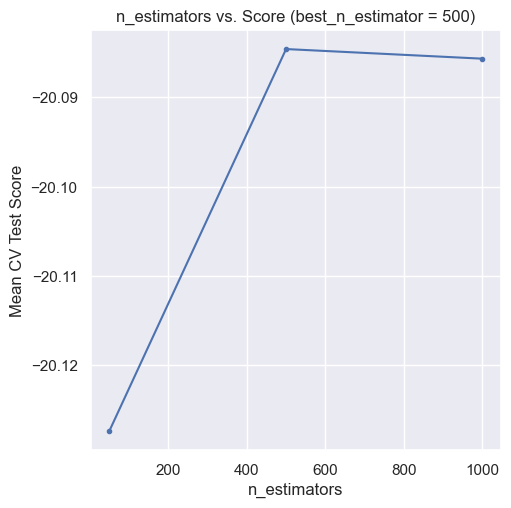

In [109]:
fig=plt.figure(figsize=(18, 12))

axes=fig.add_subplot(2, 3, 1)
axes.plot(est_score.index, est_score.values, marker='.')
axes.set(xlabel='n_estimators', ylabel='Mean CV Test Score', title='n_estimators vs. Score (best_n_estimator = 500)')

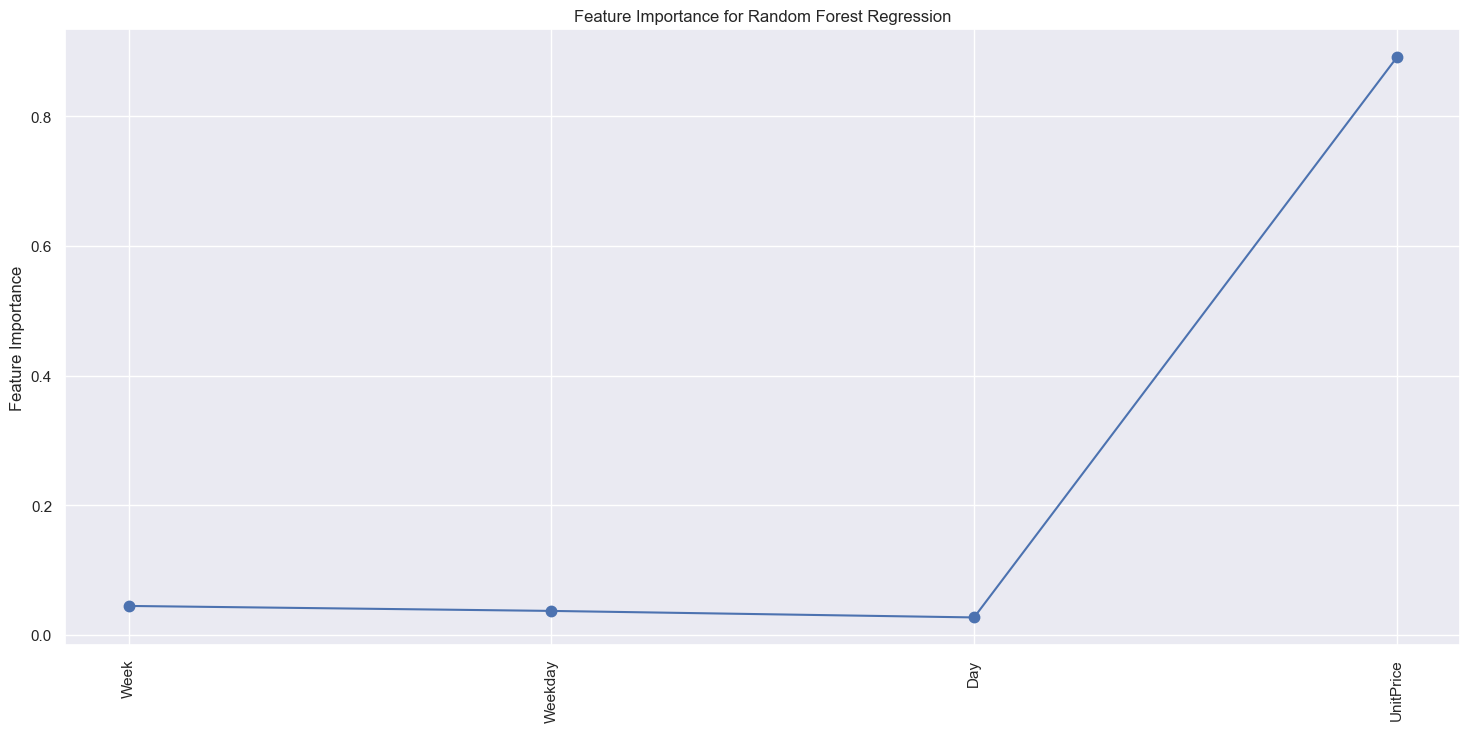

In [110]:
fig = plt.figure(figsize=(18, 8))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rf_main.best_estimator_.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(rf_main.best_estimator_.feature_importances_)), X_train.columns,rotation=90)
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Regression')

plt.show()

## Ensemble Method - Gradient Boost


In [ ]:
# The code for hyperparameter tuning is commented out as it takes a long time to run 

# Tuning the hyperparameters

from sklearn.ensemble import GradientBoostingRegressor

param_distributions = {'n_estimators': [50,100,500,1000], 'learning_rate':[0.01, 0.05, 0.1],'max_features':['auto'], 'min_samples_leaf':[1, 3, 7, 10], 'min_samples_split':[2,5,10]}
grad_boost = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_distributions, verbose=2, n_iter = 100,cv=5, scoring=rmse_cv)
grad_boost.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000; total time= 1.3min
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000; total time= 1.3min
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   3.5s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   3.5s
[CV] END learning_rate=0.01, max_features=auto, mi

In [112]:
print('Best parameters for Gradient Boost Model: {}'.format(grad_boost.best_params_))

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
# Following code uses the best parameters generated above to fit the model

from sklearn.ensemble import GradientBoostingRegressor

param_distributions = {'n_estimators': [500], 'learning_rate':[0.01],'max_features':['sqrt'], 'min_samples_leaf':[10], 'max_depth':[60], 'min_samples_split':[2]}
grad_boost = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_distributions, n_iter = 100,cv=5, scoring=rmse_cv)
%time grad_boost.fit(X_train, y_train)

In [ ]:
print('Best parameters for Gradient Boost Model: {}'.format(grad_boost.best_params_))

In [ ]:
param_summary = [grad_boost.best_params_,'']

%time rmse_summary, y_predict_summary = model_fit(grad_boost, X_train, y_train, X_test, y_test)
ypred_test['GB'] = y_predict_summary[1]
ypred_train['GB'] = y_predict_summary[0]

algo_score.loc['Gradient Boost'] = rmse_summary+param_summary

In [ ]:
algo_score.loc['Gradient Boost', 'Training+Test Time(sec)'] = 89.796
cv_time.append(89.796)
algo_score

### Visualize the mean score against different values for n estimators

Parts of code have been commenting out as they take long time to execute



In [ ]:
gb_result=pd.DataFrame(grad_boost.cv_results_)
gb_result

In [ ]:
gb_score = gb_result.groupby('param_n_estimators')['mean_test_score'].mean()
gb_score

In [ ]:
fig=plt.figure(figsize=(18, 12))

axes=fig.add_subplot(2, 3, 1)
axes.plot(gb_score.index, gb_score.values, marker='.')
axes.set(xlabel='n_estimators', ylabel='Mean CV Test Score', title='n_estimators vs. Score (best_n_estimator = 500)')

In [ ]:
fig = plt.figure(figsize=(18, 8))
axes = fig.add_subplot(1, 1, 1)
axes.plot(grad_boost.best_estimator_.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(grad_boost.best_estimator_.feature_importances_)), X_train.columns,rotation=90)
axes.set(ylabel='Feature Importance', title='Feature Importance for Gradient Boost Regressor')
# axes.set(xlim=[-1, len(X_train.columns)], ylim=[0, 1])

plt.show()

# SUMMARY AND CONCLUSIONS


## RMSE


In [ ]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.3
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Train RMSE', x=idx, color='g', width=bar_width, label='Training Data')
plt.bar(data=algo_score, height='Test RMSE', x=idx+bar_width, color='b', width=bar_width, label='Test Data')
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('RMSE')
plt.title('Average RMSE for different Modelling Algorithms')
plt.legend()
plt.show()

From the above plot, we can see that Random Forest and Gradient Boost give us very similar and the best predictions with least RMSE. Comparing the train and test data predictions, the model seems to be be overfitted. But we are not much worried about it, as despite overfitting, we are getting good results on the test data.

In order to decide between Random Forest and Gradient Boost, let us look at the time taken in fitting the model. In all the algorithms, the prediction time was very small in comparison to the fit time.



## Train/Test Time

In [ ]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.6
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Training+Test Time(sec)', x=idx, width=bar_width)
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('Training+Test Time(sec)')
plt.title('Training Time + Test Time for different Models (sec)')
#axes.set_yscale('log')
plt.show()

As seen above, Gradient Boost is taking much lesser time as compared to Random Forest. So we choose Gradient Boost as our final algorithm. Gradient Boost gives an RMSE of 0.625 on our test data.